### This notebook contains the code to generate plots to visualize result from benchmarking the fragmentation approach.

### Author: Chop Yan Lee

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns
import sqlalchemy, db_utils, glob, os, requests, itertools, re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)
global_color = 'tab:grey'
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/imb-luckgr2/projects/AlphaFold/de_novo_predictions/Plots/benchmark_fragmentation/'

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [3]:
def parse_prediction_name(prediction_name):
    """Parse out useful information from the name of prediction
    
    Args:
    prediction_name (str): Saved in consistent format
    
    Returns:
    proteinA (str): UniProt ID of the first protein region
    typeA (str): 'O' or 'D' that denotes ordered or disordered type of region respectively
    startA (int): Start of the region of the first protein
    endA (int): End of the region of the first protein
    proteinB (str): Same as above but for the second protein
    typeB (str): Same as above
    startB (int): Same as above
    endB (int): Same as above"""
    regionA, regionB = re.sub(r'run\d+_','',prediction_name).split('.')
    protA, typeA, startA, endA = regionA.split('_')
    protB, typeB, startB, endB = regionB.split('_')

    return protA, typeA, int(startA), int(endA), protB, typeB, int(startB), int(endB)

In [4]:
# query the database for prediction result
run_ids = [94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113]
query_run = ','.join([f'\'run{run_id}\'' for run_id in run_ids])
query = f"""select * from chopyan_db.AlphaFold_prediction_result
where project_name = 'AlphaFold_benchmark_fragmentation' and run_id in ({query_run}) and model_id != 'Prediction failed';"""
df = pd.read_sql_query(query,con=connect)
df

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_atoms_domain,align_score_domain,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat
0,AlphaFold_benchmark_fragmentation,run100_P06729_D_235_245.Q12834_O_166_475,run100,11,310,ranked_0,0.585495,50.236249,94.625000,78.483636,...,None,None,None,None,None,None,None,None,None,None
1,AlphaFold_benchmark_fragmentation,run100_P06729_D_235_245.Q12834_O_166_475,run100,11,310,ranked_1,0.541164,44.867500,94.429334,77.190435,...,None,None,None,None,None,None,None,None,None,None
2,AlphaFold_benchmark_fragmentation,run100_P06729_D_235_245.Q12834_O_166_475,run100,11,310,ranked_2,0.496836,33.494445,93.518332,67.793809,...,None,None,None,None,None,None,None,None,None,None
3,AlphaFold_benchmark_fragmentation,run100_P06729_D_235_245.Q12834_O_166_475,run100,11,310,ranked_3,0.484334,33.574444,92.510000,67.251905,...,None,None,None,None,None,None,None,None,None,None
4,AlphaFold_benchmark_fragmentation,run100_P06729_D_235_245.Q12834_O_166_475,run100,11,310,ranked_4,0.365729,30.539999,95.942858,72.160000,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55215,AlphaFold_benchmark_fragmentation,run99_O95400_O_63_110.Q8WUM4_O_362_715,run99,48,354,ranked_0,0.460094,37.216571,81.990811,60.225555,...,None,None,None,None,None,None,None,None,None,None
55216,AlphaFold_benchmark_fragmentation,run99_O95400_O_63_110.Q8WUM4_O_362_715,run99,48,354,ranked_1,0.373863,35.806875,83.348333,64.331750,...,None,None,None,None,None,None,None,None,None,None
55217,AlphaFold_benchmark_fragmentation,run99_O95400_O_63_110.Q8WUM4_O_362_715,run99,48,354,ranked_2,0.335444,29.146111,80.387083,58.426666,...,None,None,None,None,None,None,None,None,None,None
55218,AlphaFold_benchmark_fragmentation,run99_O95400_O_63_110.Q8WUM4_O_362_715,run99,48,354,ranked_3,0.305865,29.961667,77.572121,57.525614,...,None,None,None,None,None,None,None,None,None,None


In [5]:
df = df.groupby(['prediction_name']).agg({'model_confidence':max,'chainA_intf_avg_plddt':max,'chainB_intf_avg_plddt':max}).reset_index()
df['chainA_intf_avg_plddt'] = df['chainA_intf_avg_plddt'] / 100
df['chainB_intf_avg_plddt'] = df['chainB_intf_avg_plddt'] / 100
df

,prediction_name,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt
0,run100_P06729_D_235_245.Q12834_O_166_475,0.585495,0.502362,0.959429
1,run100_P06729_D_235_255.Q12834_O_166_475,0.525245,0.447163,0.917706
2,run100_P06729_D_235_265.Q12834_O_166_475,0.440338,0.389314,0.906495
3,run100_P06729_D_235_351.Q12834_O_166_475,0.275393,0.289954,0.965132
4,run100_P06729_D_240_250.Q12834_O_166_475,0.608503,0.512700,0.938055
...,...,...,...,...
11039,run99_O95400_O_63_110.Q8WUM4_D_856_866,0.150388,0.620633,0.457850
11040,run99_O95400_O_63_110.Q8WUM4_D_861_868,0.125804,0.514700,0.396900
11041,run99_O95400_O_63_110.Q8WUM4_O_1_319,0.351376,0.374486,0.889687
11042,run99_O95400_O_63_110.Q8WUM4_O_1_361,0.405742,0.355200,0.871621


In [6]:
df['run_id'] = [ele.split('_')[0] for ele in df['prediction_name']]
df[['uniprotA','fragment_typeA','startA','endA','uniprotB','fragment_typeB','startB','endB']] = df.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                                                        axis=1,result_type='expand')
df['prediction_type'] = ['ordered-ordered' if (a == 'O') and (b == 'O') else 'ordered-disordered' for a, b in zip(df['fragment_typeA'],df['fragment_typeB'])]
df

,prediction_name,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,run_id,uniprotA,fragment_typeA,startA,endA,uniprotB,fragment_typeB,startB,endB,prediction_type
0,run100_P06729_D_235_245.Q12834_O_166_475,0.585495,0.502362,0.959429,run100,P06729,D,235,245,Q12834,O,166,475,ordered-disordered
1,run100_P06729_D_235_255.Q12834_O_166_475,0.525245,0.447163,0.917706,run100,P06729,D,235,255,Q12834,O,166,475,ordered-disordered
2,run100_P06729_D_235_265.Q12834_O_166_475,0.440338,0.389314,0.906495,run100,P06729,D,235,265,Q12834,O,166,475,ordered-disordered
3,run100_P06729_D_235_351.Q12834_O_166_475,0.275393,0.289954,0.965132,run100,P06729,D,235,351,Q12834,O,166,475,ordered-disordered
4,run100_P06729_D_240_250.Q12834_O_166_475,0.608503,0.512700,0.938055,run100,P06729,D,240,250,Q12834,O,166,475,ordered-disordered
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11039,run99_O95400_O_63_110.Q8WUM4_D_856_866,0.150388,0.620633,0.457850,run99,O95400,O,63,110,Q8WUM4,D,856,866,ordered-disordered
11040,run99_O95400_O_63_110.Q8WUM4_D_861_868,0.125804,0.514700,0.396900,run99,O95400,O,63,110,Q8WUM4,D,861,868,ordered-disordered
11041,run99_O95400_O_63_110.Q8WUM4_O_1_319,0.351376,0.374486,0.889687,run99,O95400,O,63,110,Q8WUM4,O,1,319,ordered-ordered
11042,run99_O95400_O_63_110.Q8WUM4_O_1_361,0.405742,0.355200,0.871621,run99,O95400,O,63,110,Q8WUM4,O,1,361,ordered-ordered


In [7]:
all_uniprot = set(df['uniprotA'].to_list() + df['uniprotB'].to_list())
all_uniprot = ','.join([f"\'{uniprot}\'" for uniprot in all_uniprot])
query = f"""select uniprot_id, hgnc_symbol from milena_db.Biomart_mapping_dataset
where uniprot_id in ({all_uniprot});"""
uniprot_gene = pd.read_sql_query(query,con=connect)
uniprot_gene = dict(zip(uniprot_gene['uniprot_id'],uniprot_gene['hgnc_symbol']))
uniprot_gene

{'Q5SW96': 'LDLRAP1',
 'Q12834': 'CDC20',
 'O94907': 'DKK1',
 'Q9H2K2': 'TNKS2',
 'O95400': 'CD2BP2',
 'P12004': 'PCNA',
 'O75381': 'PEX14',
 'P55211': 'CASP9',
 'P06729': 'CD2',
 'Q96AE4': 'FUBP1',
 'Q07820': 'MCL1',
 'Q8WY41': 'NANOS1',
 'Q15637': 'SF1',
 'O75581': 'LRP6',
 'Q9H0R8': 'GABARAPL1',
 'P50542': 'PEX5',
 'Q00987': 'MDM2',
 'Q8N4B1': 'PHETA1',
 'O60566': 'BUB1B',
 'A5YKK6': 'CNOT1',
 'Q93009': 'USP7',
 'P63010': 'AP2B1',
 'Q14596': 'NBR1',
 'P04637': 'TP53',
 'P26368': 'U2AF2',
 'Q14145': 'KEAP1',
 'Q16236': 'NFE2L2',
 'Q8WUM4': 'PDCD6IP',
 'O60239': 'SH3BP5',
 'P53779': 'MAPK10',
 'O75340': 'PDCD6',
 'Q9BPZ3': 'PAIP2',
 'Q9UBT6': 'POLK',
 'P03372': 'ESR1',
 'Q15596': 'NCOA2',
 'Q9UHX1': 'PUF60',
 'P11940': 'PABPC1',
 'Q01968': 'OCRL',
 'P98170': 'XIAP'}

In [30]:
run_id_hgnc = {}
run_id_uniprot = {}
for i, r in df.iterrows():
    run_id = r['run_id']
    if run_id in run_id_hgnc:
        continue
    uniprotA = r['uniprotA']
    uniprotB = r['uniprotB']
    run_id_uniprot[run_id] = f"{uniprotA}-{uniprotB}"
    run_id_hgnc[run_id] = f"{uniprot_gene.get(uniprotA)}-{uniprot_gene.get(uniprotB)}"
run_id_hgnc

{'run100': 'CD2-CDC20',
 'run101': 'BUB1B-KEAP1',
 'run102': 'MDM2-NFE2L2',
 'run103': 'TP53-TNKS2',
 'run104': 'MCL1-USP7',
 'run105': 'XIAP-MDM2',
 'run106': 'CNOT1-CASP9',
 'run107': 'OCRL-NANOS1',
 'run108': 'PABPC1-PHETA1',
 'run109': 'PCNA-PAIP2',
 'run110': 'U2AF2-POLK',
 'run111': 'AP2B1-SF1',
 'run112': 'MAPK10-LDLRAP1',
 'run113': 'SH3BP5-GABARAPL1',
 'run94': 'LRP6-NBR1',
 'run95': 'DKK1-PUF60',
 'run96': 'ESR1-FUBP1',
 'run97': 'PEX14-NCOA2',
 'run98': 'PDCD6-PEX5',
 'run99': 'CD2BP2-PDCD6IP'}

In [31]:
run_id_uniprot

{'run100': 'P06729-Q12834',
 'run101': 'O60566-Q14145',
 'run102': 'Q00987-Q16236',
 'run103': 'P04637-Q9H2K2',
 'run104': 'Q07820-Q93009',
 'run105': 'P98170-Q00987',
 'run106': 'A5YKK6-P55211',
 'run107': 'Q01968-Q8WY41',
 'run108': 'P11940-Q8N4B1',
 'run109': 'P12004-Q9BPZ3',
 'run110': 'P26368-Q9UBT6',
 'run111': 'P63010-Q15637',
 'run112': 'P53779-Q5SW96',
 'run113': 'O60239-Q9H0R8',
 'run94': 'O75581-Q14596',
 'run95': 'O94907-Q9UHX1',
 'run96': 'P03372-Q96AE4',
 'run97': 'O75381-Q15596',
 'run98': 'O75340-P50542',
 'run99': 'O95400-Q8WUM4'}

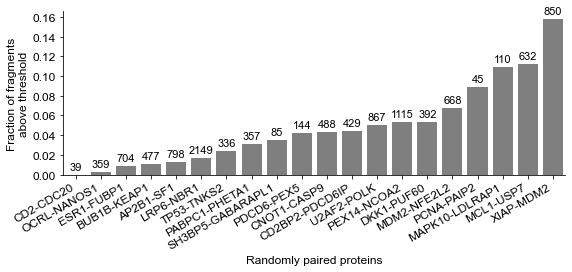

In [32]:
temp1 = df[df['prediction_type'] == 'ordered-ordered'][['prediction_name','run_id','prediction_type','model_confidence']]
temp1.rename({'model_confidence':'metric'},axis=1,inplace=True)

temp2 = df[df['prediction_type'] == 'ordered-disordered'].copy()
temp2['metric'] = [plddtA if fragment_typeA == 'D' else plddtB for plddtA,plddtB,fragment_typeA in zip(temp2['chainA_intf_avg_plddt'],
                                                                                                     temp2['chainB_intf_avg_plddt'],
                                                                                                     temp2['fragment_typeA'])]
temp2 = temp2[['prediction_name','run_id','prediction_type','metric']].copy()

temp = pd.concat([temp1,temp2],axis=0,ignore_index=True)

temp3 = temp[['prediction_name','run_id']].groupby('run_id').count().reset_index().rename({'prediction_name':'prediction_count'},axis=1)
temp4 = temp[temp['metric'] >= 0.7][['prediction_name','run_id']].groupby('run_id').count().reset_index().rename({'prediction_name':'prediction_above_threshold'},axis=1)

temp = pd.merge(temp3,temp4,'outer')
temp.replace({np.nan:0},inplace=True)
temp['fraction_above_threshold'] = temp['prediction_above_threshold'] / temp['prediction_count']

temp.sort_values('fraction_above_threshold',ascending=True,inplace=True)
temp.reset_index(drop=True,inplace=True)

fig, ax = plt.subplots(figsize=(9,3))

bars = ax.bar(x=temp['run_id'],height=temp['fraction_above_threshold'],color=global_color)

for i, r in temp.iterrows():
    ax.annotate(f"{r['prediction_count']}",xy=(i,r['fraction_above_threshold']),ha='center',va='bottom',
                 textcoords="offset points",xytext=(0,3),fontsize=global_fontsize-1)

ax.set_xticks(range(temp['run_id'].nunique()))
ax.set_xlim([-0.5,temp['run_id'].nunique()-0.5])
ax.set_xticklabels([run_id_hgnc.get(run_id) for run_id in temp['run_id'].to_list()],fontsize=global_fontsize,
                  rotation=30,ha='right')

modify_ticks_and_labels(ax,y_major_multiple=0.02,y_minor_multiple=0.02)
ax.set_ylabel('Fraction of fragments\nabove threshold',fontsize=global_fontsize)
ax.set_xlabel('Randomly paired proteins',fontsize=global_fontsize)

plt.savefig(f'{save_path}RRS_fraction_fragment_above_threshold.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}RRS_fraction_fragment_above_threshold.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

plt.show()

In [35]:
temp['uniprot'] = [run_id_uniprot.get(run_id) for run_id in temp['run_id']]
temp[['uniprotA','uniprotB']] = [ele.split('-') for ele in temp['uniprot']]
temp

,run_id,prediction_count,prediction_above_threshold,fraction_above_threshold,uniprot,uniprotA,uniprotB
0,run100,39,0.0,0.000000,P06729-Q12834,P06729,Q12834
1,run107,359,1.0,0.002786,Q01968-Q8WY41,Q01968,Q8WY41
2,run96,704,6.0,0.008523,P03372-Q96AE4,P03372,Q96AE4
3,run101,477,5.0,0.010482,O60566-Q14145,O60566,Q14145
4,run111,798,10.0,0.012531,P63010-Q15637,P63010,Q15637
5,run94,2149,36.0,0.016752,O75581-Q14596,O75581,Q14596
6,run103,336,8.0,0.023810,P04637-Q9H2K2,P04637,Q9H2K2
7,run108,357,11.0,0.030812,P11940-Q8N4B1,P11940,Q8N4B1
8,run113,85,3.0,0.035294,O60239-Q9H0R8,O60239,Q9H0R8
9,run98,144,6.0,0.041667,O75340-P50542,O75340,P50542


In [36]:
# export for publicatin
temp.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/fragmentation_benchmark_RRS_above_threshold.tsv',
         sep='\t',index=None)

In [26]:
# export for publicatin
temp_df = df.copy()
temp_df['prediction_name'] = temp_df['prediction_name'].str.replace(r'(run\d+_)','')
temp_df.to_csv('/Volumes/imb-luckgr/manuscripts/AlphaFold_paper/tables/fragmentation_benchmark_prediction_raw.tsv',
         sep='\t',index=None)

<ipython-input-26-3c9630cb68ab>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  temp_df['prediction_name'] = temp_df['prediction_name'].str.replace(r'(run\d+_)','')
